# Social Clustering and Individualism

### Jeremy Ryan

Within a population of humans, there tends to be a balance of diversity and clustering of opinion — that is, for any continuous stance (say, degree of support for speed limit enforcement) there tend to be social clusters with some amount of consensus within and some amount of variance between each cluster. This phenomenon is called pluralism.

This notebook is an effort to recreate the agent-based model described in a [paper by Mäs et all](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000959) and extend the model in a useful way. You can read more about this project from the [corresponding Github repository](https://github.com/jeremycryan/social-clustering).

In [1]:
import random
import math
import statistics

import matplotlib.pyplot as plt

### Agent Class

Agents in the Mäs et al paper balance homophily with individualism.

In [2]:
class Agent(object):
    """ Represents a single agent with an opinion. """
    
    A = 2    # Parameter representing range of social influence --- see paper
    s = 3.5  # Parameter representing strength of disintegrating force --- see paper
    
    min_opinion = -250
    max_opinion = 250
    
    social_influences = None
    
    def __init__(self, population):
        self.opinion = random.gauss(0, 10)   # TODO properly define initial condition for opinions
        self.apply_opinion_threshold()
        self.population = population
        
    def update(self):
        """ Updates the current agent's opinion based on the state of the population. """
        self.opinion += self.total_social_influence() + self.gaussian_term()
        self.apply_opinion_threshold()
        self.reset_stored_vars()
        
    def reset_stored_vars(self):
        """ Resets the variables stored each time step. """
        self.social_influences = None

    def apply_opinion_threshold(self):
        """ Limits the opinion of the agent to be within defined min and max values. """
        self.opinion = min(self.opinion, self.max_opinion)
        self.opinion = max(self.opinion, self.min_opinion)
    
    def other_agents(self):
        """ Generator function to yield all agents except this one. """
        for agent in self.population.agents:
            if agent is not self:
                yield agent
                
    def social_influence(self, other):
        """ Calculate the degree to which another Agent influences
            this one; increases with more similar opinion
        """
        exponent = -abs(self.opinion - other.opinion)/self.A
        return math.exp(exponent)
    
    def total_social_influence(self):
        """ Returns a weighted sum of difference of opinion between other agents,
            with weights of each other agent's social influence, normalized
            to the total social influence of all other agents.
        """
        self.social_influences = {}
        for other in self.other_agents():
            self.social_influences[other] = self.social_influence(other)
        
        numerator = sum([(other.opinion - self.opinion) 
                         * self.social_influences[other] 
                         for other in self.other_agents()])
        
        denominator = sum([self.social_influences[other]
                          for other in self.other_agents()])
        
        return numerator/denominator
    
    def gaussian_term(self):
        """ Returns a random value, based on parameters A and s. """
        
        std_dev = self.s * sum([self.social_influences[other]**self.A
                                for other in self.other_agents()])
        return random.gauss(0, std_dev)

### Population Class

The population class represents a collection of Agents.

In [3]:
class Population(object):
    """ Represents a population of Agents. """
    
    def __init__(self):
        self.agents = set()

    def populate(self, n=100):
        """ Add n new agents to the Population. """
        new_agents = set(Agent(self) for _ in range(n))
        self.agents |= new_agents

    def update_all(self):
        """ Update all agents in the Population. """
        for agent in self.agents:
            agent.update()
            
    def update_random(self, n=1):
        """ Update n random Agents in the Population. """
        for agent in random.sample(self.agents, n):
            agent.update()
            
    def each_opinion(self):
        """ Returns a list of the opinion of all agents. """
        return [agent.opinion for agent in self.agents]
    
    def average_opinion(self):
        """ Yields the average opinion of all agents. """
        opinions = self.each_opinion()
        return sum(opinions)/len(opinions)

### Simulation

Lets see what happens when we run a population of 100 agents for a few thousand time steps.

In [4]:
# Instantiate population and add agents
pop_size = 50
updates_per_step = pop_size
pop = Population()
pop.populate(n=pop_size)

# Record average opinion and the opinion of each agent
num_steps = 5000
x = list(range(num_steps))
avg_o = []
ys = []

for x_val in x:
    avg_o.append(pop.average_opinion())
    ys.append(pop.each_opinion())
    pop.update_random(updates_per_step)

ys = list(zip(*ys))

This plot should look similar to the [clustering plot](https://journals.plos.org/ploscompbiol/article/figure/image?size=large&id=info:doi/10.1371/journal.pcbi.1000959.g002) in the source paper, in that it has multiple opinion clusters that change over time.

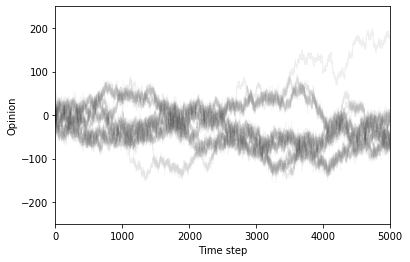

In [5]:
for item in ys:
    plt.plot(x, item, 'k', linewidth=1, alpha=0.03)
#plt.plot(x, avg_o, 'k', linewidth=3)

plt.xlim([0, num_steps])
plt.ylim([-250, 250])
plt.xlabel("Time step")
plt.ylabel("Opinion")
plt.show()